In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import arange

In [2]:
os.chdir('../')

In [3]:
%%capture
from nutrition_labels.grant_tagger import GrantTagger

In [4]:
data = pd.read_csv('data/processed/training_data.csv')

(array([  6.,   2.,   2.,   9.,  12.,  22.,  30.,  65., 182., 438., 161.,
         52.,  35.,  18.,  14.,   2.,   7.,   2.,   6.,   8.,   2.,   0.,
          2.,   5.,   3.,   2.,   3.,   0.,   3.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([ 102.  ,  234.62,  367.24,  499.86,  632.48,  765.1 ,  897.72,
        1030.34, 1162.96, 1295.58, 1428.2 , 1560.82, 1693.44, 1826.06,
        1958.68, 2091.3 , 2223.92, 2356.54, 2489.16, 2621.78, 2754.4 ,
        2887.02, 3019.64, 3152.26, 3284.88, 3417.5 , 3550.12, 3682.74,
        3815.36, 3947.98, 4080.6 , 4213.22, 4345.84, 4478.46, 4611.08,
        4743.7 , 4876.32, 5008.94, 5141.56, 5274.18, 5406.8 , 5539.42,
        5672.04, 5804.66, 5937.28, 6069.9 , 6202.52, 6335.14, 6467.76,
        6600.38, 6733.  ]),
 <BarContainer object of 50 artists>)

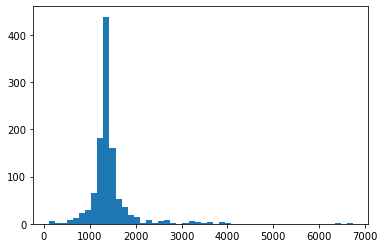

In [5]:
plt.hist(data['Description'].apply(len), bins=50)

In [6]:
len([d for d in data['Description'] if len(d)<500])

10

In [7]:
def run_experiment(sample_not_relevant_range, num_repeats, vectorizer_type,model_type = 'naive_bayes',bert_type = 'bert'):
    experiments_results = []
    grant_tagger = GrantTagger(
                ngram_range=(1,2),
                test_size=0.25,
                vectorizer_type = vectorizer_type,
                model_type = model_type,
                bert_type = bert_type
            )
    X_vect,y = grant_tagger.transform(data)
    for n in sample_not_relevant_range:
        average_results_train = None
        average_results_test = None
        for i in range(0, num_repeats):
            # Take the average of 5 runs

            X_train, X_test, y_train, y_test = grant_tagger.split_data(
                X_vect,
                y,
                sample_not_relevant = n,
                irrelevant_sample_seed = i,
                split_seed=i
                )
            grant_tagger.fit(X_train, y_train)
            results_train = grant_tagger.evaluate(X_train, y_train, print_results=False, average='weighted')
            results_test = grant_tagger.evaluate(X_test, y_test, print_results=False, average='weighted')
            if average_results_train: # will be the same for test too
                for key in average_results_train.keys(): # will be the same for test too
                    average_results_train[key] += results_train[key]
                    average_results_test[key] += results_test[key]
            else:
                average_results_train = results_train
                average_results_test = results_test
        average_results_train = {key: value/num_repeats for key, value in average_results_train.items()}
        average_results_test = {key: value/num_repeats for key, value in average_results_test.items()}
        results_dict = {'sample_not_relevant': n}
        for key, value in average_results_train.items():
            results_dict[key+'_train'] = value
        for key, value in average_results_test.items():
            results_dict[key+'_test'] = value
        experiments_results.append(results_dict)
        
    return experiments_results

In [8]:
def plot_results(experiments_results_df):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='accuracy_train',ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='accuracy_test', color='red', ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='f1_train',ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='f1_test', color='red', ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='precision_score_train',ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='precision_score_test', color='red', ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='recall_score_train',ax=ax4, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='recall_score_test', color='red', ax=ax4, marker='.')
    # fig.savefig(f'sample_not_relevant_{num_repeats}reps_{vectorizer_type}.png')
    # plt.close(fig)
    plt.show()

In [9]:
count_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='count'
)

TypeError: split_data() got an unexpected keyword argument 'sample_not_relevant'

In [ ]:
experiments_results_df = pd.DataFrame(count_experiments_results)
plot_results(experiments_results_df)

In [ ]:
tfidf_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='tfidf'
)

In [ ]:
experiments_results_df = pd.DataFrame(tfidf_experiments_results)
plot_results(experiments_results_df)

In [ ]:
print(len(data.loc[data['Relevance code'] == 1]))
print(len(data.loc[data['Relevance code'] == 0]))

## Explore all the results of those with good parameters

In [ ]:
def test_setting(data, vectorizer_type, n, model_type = 'naive_bayes',bert_type = 'bert'):
    i = 4
    grant_tagger = GrantTagger(
                ngram_range=(1,2),
                test_size=0.25,
                vectorizer_type = vectorizer_type,
                model_type = model_type,
                bert_type = bert_type
            )
    X_vect,y = grant_tagger.transform(data)
    X_train, X_test, y_train, y_test = grant_tagger.split_data(
                X_vect,
                y,
                sample_not_relevant = n,
                irrelevant_sample_seed = i,
                split_seed=i
                )
    grant_tagger.fit(X_train, y_train)
    results_train = grant_tagger.evaluate(X_train, y_train, average='weighted')
    results_test = grant_tagger.evaluate(X_test, y_test, average='weighted')

In [ ]:
test_setting(data, 'tfidf', 0.2)

In [ ]:
test_setting(data, 'tfidf', 1.1)

In [ ]:
test_setting(data, 'count', 0.2)

In [ ]:
test_setting(data, 'count', 1.625)

## Testing Bert Vectorizer


Bert and Naive Bayes model


In [ ]:
%%capture
bert_bayes_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert'
)


In [ ]:
experiments_results_df = pd.DataFrame(bert_bayes_experiments_results)
plot_results(experiments_results_df)

Bert and SVM model


In [ ]:
%%capture
bert_svm_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='SVM'
)


In [ ]:
experiments_results_df = pd.DataFrame(bert_svm_experiments_results)
plot_results(experiments_results_df)

Bert and Logistic regression model


In [ ]:
%%capture
bert_logreg_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='log_reg'
)


In [ ]:
experiments_results_df = pd.DataFrame(bert_logreg_experiments_results)
plot_results(experiments_results_df)

## Exploring Bert Results with good parameters 

In [ ]:
test_setting(data, 'bert', 0.2)

In [ ]:
test_setting(data, 'bert', 1.775)

In [ ]:
test_setting(data, 'bert', 0.5,'SVM')

In [ ]:
test_setting(data, 'bert', 1.625,'SVM')

## Testing Scibert Vectorizer


Scibert and Naive Bayes model


In [ ]:
%%capture
scibert_bayes_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', bert_type= 'scibert'
)


In [ ]:
experiments_results_df = pd.DataFrame(scibert_bayes_experiments_results)
plot_results(experiments_results_df)

Scibert and SVM model


In [ ]:
%%capture
scibert_svm_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='SVM', bert_type= 'scibert'
)


In [ ]:
experiments_results_df = pd.DataFrame(scibert_svm_experiments_results)
plot_results(experiments_results_df)

Scibert and Logistic regression model


In [ ]:
%%capture
scibert_logreg_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='log_reg', bert_type= 'scibert'
)


In [ ]:
experiments_results_df = pd.DataFrame(scibert_logreg_experiments_results)
plot_results(experiments_results_df)

## Exploring Scibert Results with good parameters

Scibert and Naive Bayes

In [ ]:
test_setting(data, 'bert', 1.625, bert_type = 'scibert')

Scibert and SVM

In [ ]:
test_setting(data, 'bert', 0.2, 'SVM',bert_type = 'scibert')

In [ ]:
test_setting(data, 'bert', 1.175,'SVM', bert_type = 'scibert')

Scibert and log reg

In [ ]:
test_setting(data, 'bert', 0.275,'log_reg', bert_type = 'scibert')

In [ ]:
test_setting(data, 'bert', 1.7,'log_reg', bert_type = 'scibert')

test_setting(data, 'bert', 1.7,'log_reg', bert_type = 'scibert')

Scibert and Naive Bayes

In [ ]:
test_setting(data, 'bert', 1.625, bert_type = 'scibert')

Scibert and SVM

In [ ]:
test_setting(data, 'bert', 0.2, 'SVM',bert_type = 'scibert')

In [ ]:
test_setting(data, 'bert', 1.175,'SVM', bert_type = 'scibert')

Scibert and log reg

In [ ]:
test_setting(data, 'bert', 0.275,'log_reg', bert_type = 'scibert')

In [ ]:
test_setting(data, 'bert', 1.7,'log_reg', bert_type = 'scibert')